\# SeismoStats: How To
<div class="alert alert-block alert-info">

#### In this notebook we will show how to:

<ol>
    <li> Make a catalog object
    <ol>
        <li> by downloading it
        <li> by converting a csv file
    </ol>
    <li>Plot the seismicity</li>
    <li>Analyze the FMD</li>
    <ol>
         <li>Plot the FMD</li> 
        <li>Estimate the magnitude of completeness</li> 
        <li>Estimate b-values</li> 
    </ol>
    <li>Generate synthetic magnitudes</li>
    <li>Bin magnitudes</li>
</ol>

</div>

## 0. Import general packages

In [1]:
#%matplotlib widget
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## 1. Make a catalog object

<div class="alert alert-block alert-warning">
<font color=#208de2>     
The catalog object is a dataframe, with some additional methods and attributes.
The columns are:

|column header |type | importance|
|:-|:-|:-|
|latitude |float |required|
|longitude |float |required|
|depth| float| required|
|mag_type| string| optional|
|magnitude| float| required| 
|time| pandas timestamp| required|
|event_type| string| optional|
</font>
</div>

### 1.1 Download catalog

In [2]:
from seismostats import FDSNWSEventClient

<font color=#208de2> Start date and end date have to be defined as a datetime. In case something does not work out, the link to retrieve it manually is given back. </font>

In [3]:
start_time = pd.to_datetime('2020/01/01')
end_time = pd.to_datetime('2022/01/01')

min_longitude = 5
max_longitude = 11
min_latitude = 45
max_latitude = 48

min_magnitude = 0.5
url = 'http://eida.ethz.ch/fdsnws/event/1/query'
client = FDSNWSEventClient(url)
cat = client.get_events(
    start_time=start_time,
    end_time=end_time,
    min_magnitude=min_magnitude,
    min_longitude=min_longitude,
    max_longitude=max_longitude,
    min_latitude=min_latitude,
    max_latitude=max_latitude)

<font color=#208de2> The output is a catalog object</font>

In [4]:
cat.tail()

,event_type,time,latitude,longitude,depth,evaluationmode,magnitude,magnitude_type,magnitude_MLhc,magnitude_MLh
2787,quarry blast,2020-01-03 14:43:49.025320,47.187560,7.185673,-683.593750,manual,1.213024,MLh,NaN,1.213023609
2788,earthquake,2020-01-03 14:28:09.701876,46.444436,9.104820,2033.203125,manual,0.596428,MLh,NaN,0.5964283368
2789,quarry blast,2020-01-02 08:47:20.725352,47.673434,7.585486,12113.281250,manual,0.657227,MLh,NaN,0.6572274734
2790,earthquake,2020-01-01 17:42:48.508164,46.031975,6.892110,5295.898438,manual,0.826313,MLh,NaN,0.8263128507
2791,earthquake,2020-01-01 13:43:47.626410,45.704174,7.068708,3302.734375,manual,0.824352,MLh,NaN,0.8243519995


## 2. Seismicity Plots

<div class="alert alert-block alert-warning">
<font color=#208de2>     
We have three basic plots of the seismicity

<ol>
<li>Seismicity in space</li>
<li>Cumulative count</li> 
<li>Magnitudes in time</li> 
</ol>

</font>
</div>

### 2.1. Plot in space

<font color=#208de2>
It is possible to choose the resolutions 10, 50 and 110. Optionally you can choose the color scheme and the country of which you want to see the borders. For large areas/countries, the plotting can take some time.
</font>


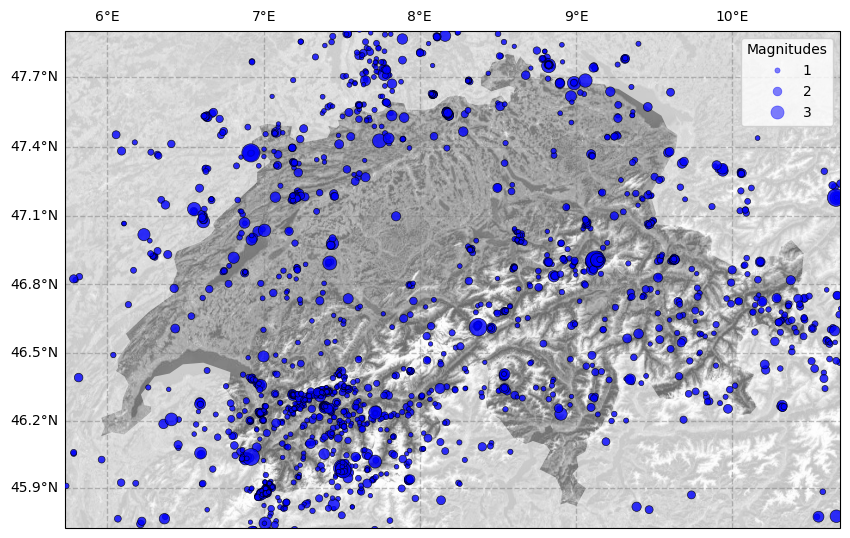

In [5]:
fig = plt.figure(figsize=(10, 10), linewidth=1)    
ax = cat.plot_in_space(
    resolution='10m',
    include_map=True,
    country='Switzerland',
    colors='Greys_r',
    dot_labels=[1,2,3])

<font color=#208de2>
You can also choose the interpolation power and the size of the smallest and largest dot. 
</font>


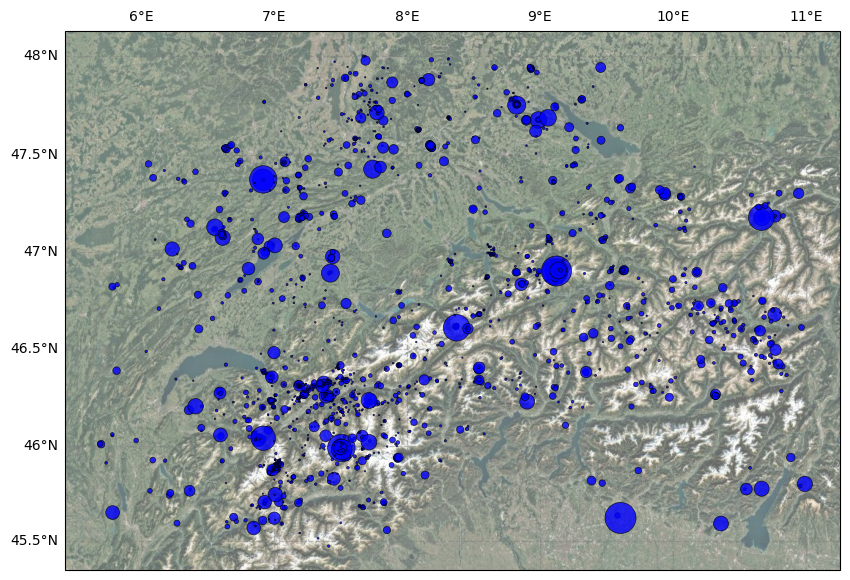

In [6]:
fig = plt.figure(figsize=(10, 10), linewidth=1)    
ax = cat.plot_in_space(
    resolution='10m',
    include_map=True,
    dot_smallest=1,
    dot_largest=500,
    dot_interpolation_power=3,
    dot_labels=None)

<font color=#208de2>
The default is that the map is not included.
</font>

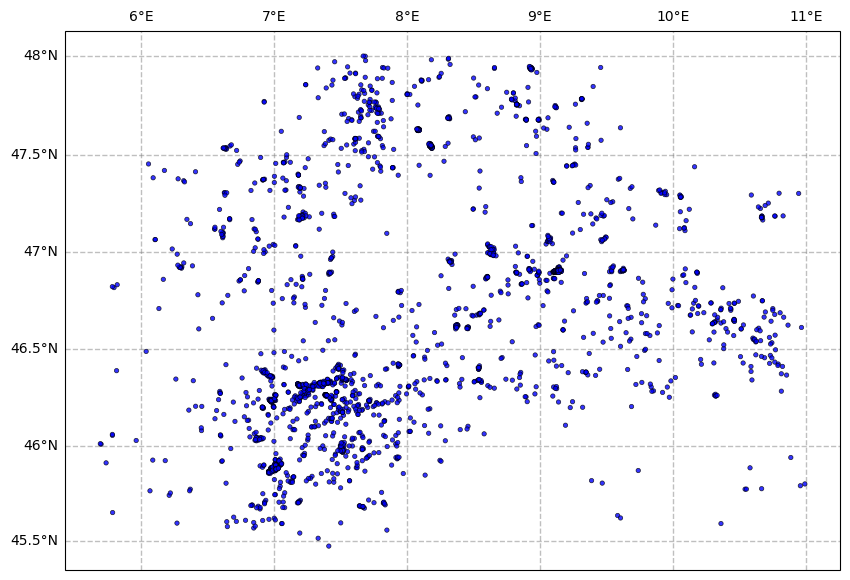

In [7]:
fig = plt.figure(figsize=(10, 10), linewidth=1)    
ax = cat.plot_in_space(
    dot_smallest=0.1,
    dot_largest=10,
    dot_interpolation_power=0,
    dot_labels=False)

### 2.2. Plot in time

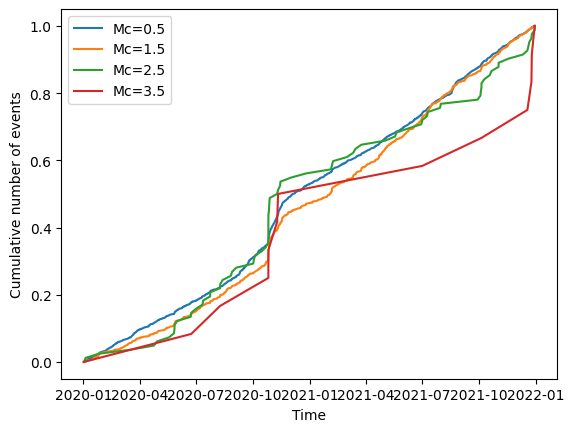

In [8]:
ax = cat.plot_cum_count(mcs=np.arange(0.5, 4.0, 1), delta_m=0.1)

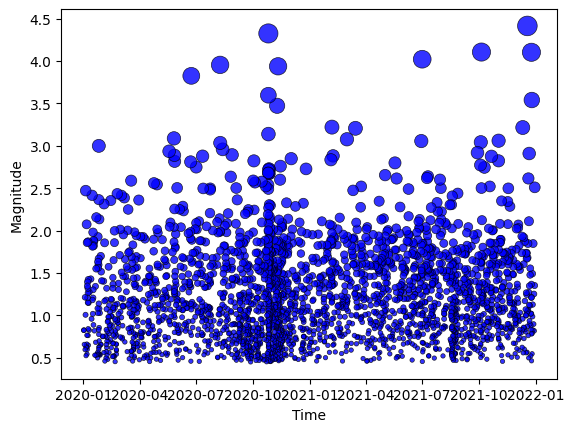

In [9]:
ax = cat.plot_mags_in_time()

## 3. analysze the FMD

### 3.1 Plot magnitude distributions

In [15]:
# bin the magnitudes (if the binning of the catalog is known, one can just set it instead with e.g. cat.delta_m = 0.01)
cat.bin_magnitudes(delta_m=0.01, inplace=True)

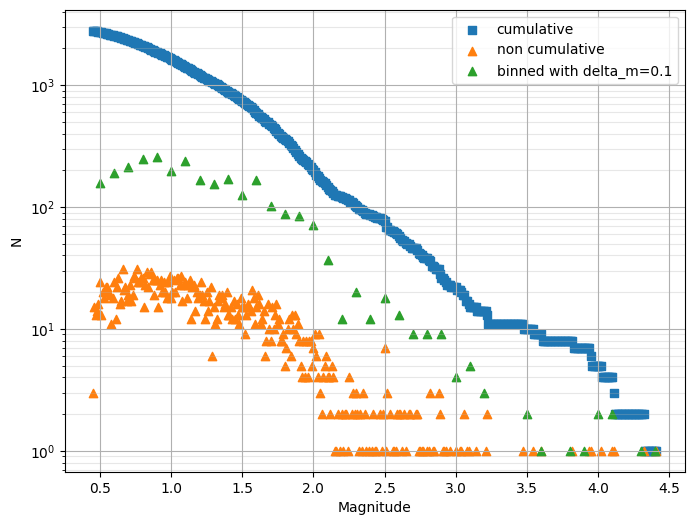

In [23]:
ax = plt.subplots(figsize=(8, 6))[1]

cat.plot_cum_fmd(ax=ax)
cat.plot_fmd(ax=ax, grid=True)

# if you want to use a different binning for the plot_fmd, you can set it here
cat.plot_fmd(delta_m = 0.1, ax=ax, grid=True, legend='binned with delta_m=0.1')

plt.show()

### 3.2 Estimate completeness magnitude

In [24]:
# estimate b-value by stability
mc_stab, best_b_value, mcs_test, b_values_test, diff_bs = cat.estimate_mc_b_stability(stop_when_passed=True)
# the b-value is saved within the catalog
cat.mc

np.float64(1.46)

In [27]:
# You have to chose a delta_m here. This is basicallhy the binning that is used for the maxc method,
# and might be different from the binning of the catalog. Originally, 0.1 was used, but the optimal
# value depends on the data. The best way is to plot_fmd and use the delta_m that makes the most sense for the user.
mc_maxc = cat.estimate_mc_maxc(delta_m=0.1)
# now, the mc is set to the one that was estimated by the maxc method.
cat.mc

np.float64(1.1)

This method takes longer, especially when the magnitude sample is large.

If Mc is known to be larger than a certain value, giving the Mc values that should be tested as an input can make the Mc estimation faster.

In [28]:
mc_kstest, b_kstest, mcs_tested, betas, ks_ds, ps = cat.estimate_mc_ks(
   mcs_test=np.arange(1.0, 3.0, 0.1),
    p_value_pass=0.1,
) 

print("Tested Mc values:", mcs_tested)
print("First Mc to pass the KS test:", mc_kstest)
print(f"Associated beta value: {b_kstest:.2f}")

/Users/aron/polybox/Projects/SeismoStats/seismostats/analysis/estimate_mc.py:214: UserWarning: Mcs to test are not binned correctly. Test might fail because of this.
  warnings.warn("Mcs to test are not binned correctly. "


Tested Mc values: [np.float64(1.0), np.float64(1.1), np.float64(1.2000000000000002), np.float64(1.3000000000000003), np.float64(1.4000000000000004), np.float64(1.5000000000000004)]
First Mc to pass the KS test: 1.5000000000000004
Associated beta value: 1.05


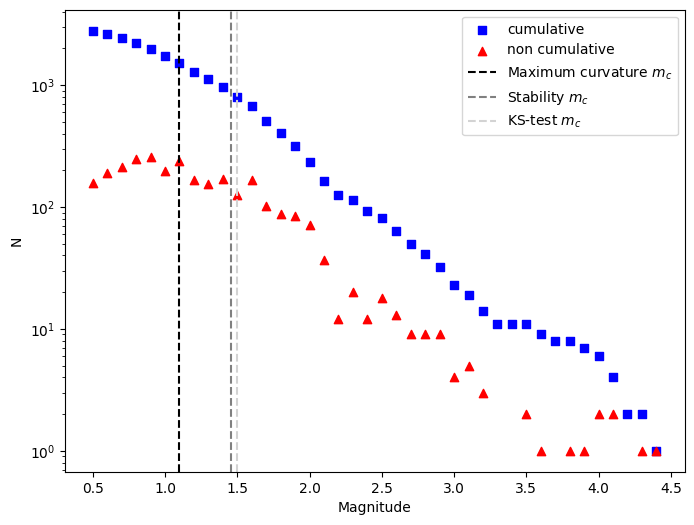

In [29]:
ax = plt.subplots(figsize=(8, 6))[1]

cat.plot_cum_fmd(delta_m=0.1, ax=ax, color='blue')
cat.plot_fmd(delta_m=0.1, ax=ax, color='red')

plt.axvline(mc_maxc, color='black', linestyle='--', label='Maximum curvature $m_c$')
plt.axvline(mc_stab, color='grey', linestyle='--', label='Stability $m_c$')
plt.axvline(mc_kstest, color='lightgrey', linestyle='--', label='KS-test $m_c$')

plt.legend()
plt.show()

### 3.3 Estimate the b-value

In [30]:
b_estimator = cat.estimate_b()
# take care:cat.delta_m and cat.mc are used here!
cat.b_value

np.float64(1.0511864759225187)

In [31]:
# the b-estimator that was given back above contains more information on the b-value estimation
print('b-value', b_estimator.b_value)
print('standard deviation', b_estimator.std)
print('number of events used', b_estimator.n)

b-value 1.0511864759225187
standard deviation 0.04033308717116795
number of events used 742


<Axes: xlabel='Magnitude', ylabel='N'>

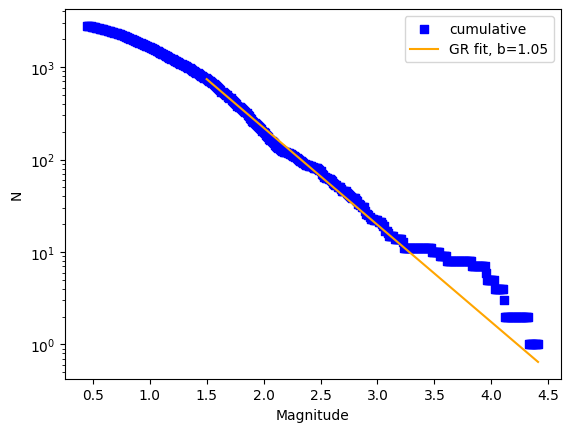

In [32]:
cat.plot_cum_fmd(color=['blue', 'orange'])

<font color=#208de2> We can also plot the b-value for different mc: </font>

<Axes: xlabel='Completeness magnitude $m_c$', ylabel='b-value'>

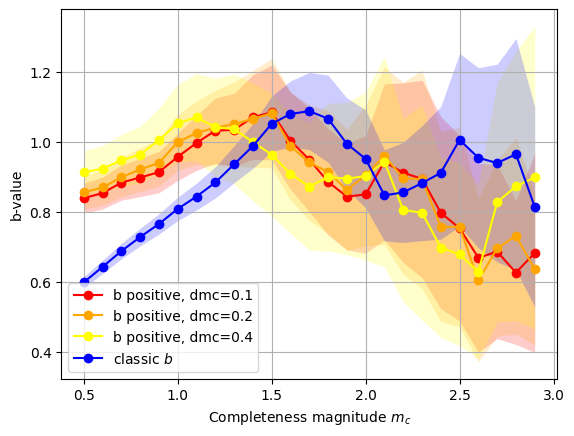

In [33]:
from seismostats.analysis import ClassicBValueEstimator, BPositiveBValueEstimator

mcs = np.arange(0.5, 3, 0.1)
ax = cat.plot_mc_vs_b(mcs, b_method=BPositiveBValueEstimator, dmc=0.1, color='red', label='b positive, dmc=0.1')
cat.plot_mc_vs_b(mcs, b_method=BPositiveBValueEstimator, dmc=0.2, ax=ax,  color='orange', label='b positive, dmc=0.2')
cat.plot_mc_vs_b(mcs, b_method=BPositiveBValueEstimator, dmc=0.4, ax=ax,  color='yellow', label='b positive, dmc=0.4')

cat.plot_mc_vs_b(mcs, b_method=ClassicBValueEstimator, ax =ax, color='blue', label='classic $b$')

### 3.4 Check if the b-value changes significantly

<font color=#208de2> Once we picked a fitting completeness, we might also want to see how the b-value changes with time (or along any other dimension). Unfortunately, this one is not yet implemented for the catalog class, so we have to use the original function </font>

In [55]:
from seismostats.analysis import b_significant_1D
from seismostats.plots import plot_b_series_constant_nm, plot_b_significant_1D
from seismostats.analysis import BPositiveBValueEstimator

In [56]:
mc = 1
delta_m = cat.delta_m

times = cat.time
mags = cat.magnitude

Text(0.5, 0, 'Time')

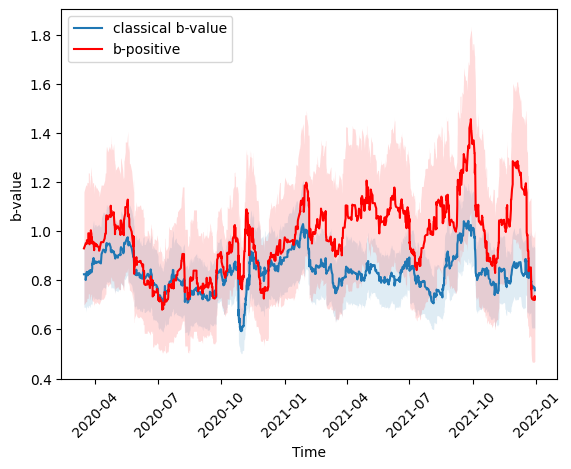

In [57]:
n_m = 100 # number of magnitudes taken per estimate in the running window

idx = mags >= 0
ax = plot_b_series_constant_nm(mags, delta_m, mc, times, n_m=n_m,x_variable=times, color='#1f77b4', plot_technique='right', label='classical b-value')

ax = plot_b_series_constant_nm(mags[idx], delta_m, mc, times[idx], n_m=n_m,x_variable=times[idx], color='red', plot_technique='right', label='b-positive', ax=ax, b_method=BPositiveBValueEstimator)

_ = plt.xticks(rotation=45)
ax.set_xlabel('Time')

<font color=#208de2> Looking at the time-series above, one could be interested if the variation of the b-value is larger than what one would expect just from random fluctuation of the estimate. In other words, we want to know if we can reject the null-hypothesis that the true b-value is constant. For this, we can apply the method of Mirwald et. al., 2024.

For this, we estimate the mean autocorrelation (MAC). The MAC can then be used to estimate a p-value. If the p-value is smaller than a threshold (which we have to choose, often 0.05 is used), then we can reject the null-hypothesis, and we are justified to believe that the b-vlue is in fact changing.  </font>

In [60]:
n_m = 100

p, mac, mu_mac, std_mac = b_significant_1D(mags, mc, delta_m, times, n_m)

# b-positive
p, mac, mu_mac, std_mac = b_significant_1D(mags, mc, delta_m, times, n_m, method= BPositiveBValueEstimator)

In [61]:
p_threshold = 0.05
print('The p-value of a constant b-value hypothesis is {:.2f}'.format(p))
print('This is significantly larger than our threshold of {:.2f}. Therefore, we cannot reject the null-hypothesis'.format(p_threshold))

The p-value of a constant b-value hypothesis is 0.16
This is significantly larger than our threshold of 0.05. Therefore, we cannot reject the null-hypothesis


<font color=#208de2> We found that the temporal variation was not significant, therefore further interpretation of how the b-value changes with time might not be reasonable to do. But this was specifically using a certain number of magnitudes per estimate. Maybe there is some other scale, where the b-value does change significantly?

We can test this easily by applying the same method with different n_m. </font>

<Axes: xlabel='$n_m$', ylabel='MAC'>

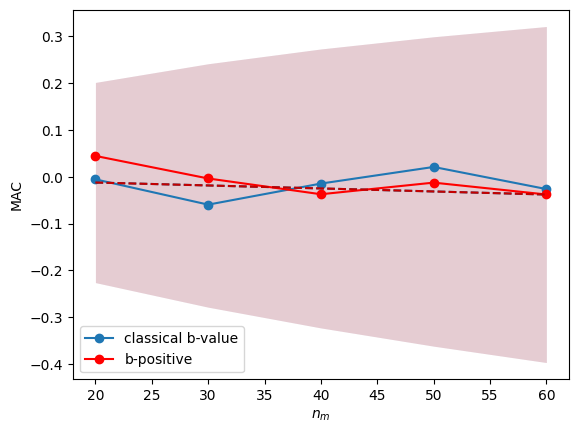

In [66]:
ax = plot_b_significant_1D(
    mags, times, mc, delta_m, x_variable = times, color = '#1f77b4', label='classical b-value')

plot_b_significant_1D(
    mags, times, mc, delta_m, x_variable = times, color = 'red', b_method=BPositiveBValueEstimator, ax = ax, label='b-positive')


<font color=#208de2> We found that in fact, the variation of the b-value is not significant within the scales that we can practically test. </font>

## 4. Generate and bin synthetic earthquakes

<div class="alert alert-block alert-warning">
<font color=#208de2>     
First we need to define the number of earthquakes, the b-value and the completeness magnitude. If binnning is applied, it is important to generate the magnitudes half a bin smaller than the smallest magnitude, otherwise the first bin will contain only half the events. For the b-value, note that beta is defined as the natural logarithm equivalent of the b-value.
</font>
</div>

In [121]:
from seismostats import Catalog
from seismostats.analysis import estimate_b
from seismostats.utils import simulate_magnitudes_binned
from seismostats.plots import plot_cum_fmd
import matplotlib.pyplot as plt

In [130]:
n = 200
b_value = 1.5
delta_m = 0.05
mc = 3
dmc = 0.3

<font color=#208de2> Now we can generate a synthetic magnitude distribution: </font>

In [131]:
mags = simulate_magnitudes_binned(n, b_value, mc, delta_m)
cat = pd.DataFrame({'magnitude': mags})
cat = Catalog(cat)
cat.delta_m = delta_m
cat.mc = mc

<font color=#208de2> Now we can estimate the b-value: </font>

In [132]:
# equivelently, you can use the Catalog method
cat.estimate_b()
print('b-value', cat.b_value)

b-value 1.4154639496733217


<font color=#208de2> We can plot the original and binned magnitudes and their respective b-value estimates now. Note that we choose the bin position to be left in order to align the binned and the original magnitudes. </font>

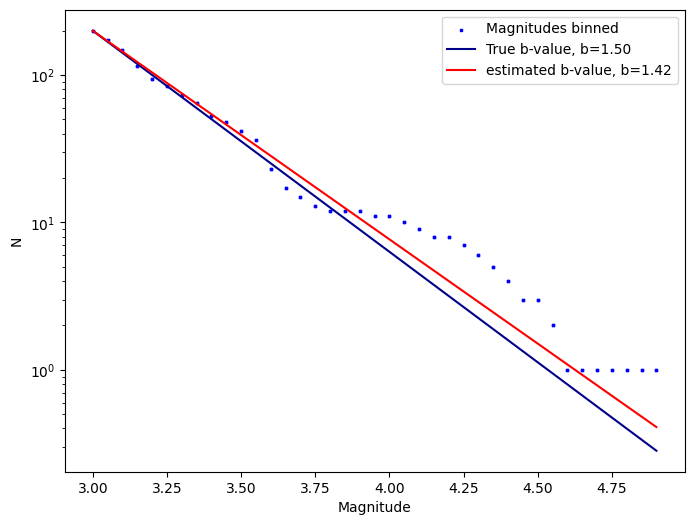

In [135]:
ax = plt.subplots(figsize=(8, 6))[1]

cat.plot_cum_fmd(ax=ax, b_value=b_value,
             color=['blue', 'darkblue'], legend=['Magnitudes binned', 'True b-value'], size=3)
cat.plot_cum_fmd(ax=ax, 
             color=['blue', 'red'], legend=['_', 'estimated b-value'], size=3)

plt.show()